# Slopes estimation

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
from collections import deque
from copy import deepcopy

from rashomon import tva
from rashomon import loss
from rashomon import counter
# from rashomon import metrics
from rashomon import extract_pools
# from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache
from rashomon.aggregate import (RAggregate_profile_slopes, RAggregate_slopes,
#     find_profile_lower_bound, find_feasible_combinations, remove_unused_poolings, subset_data
)

%load_ext autoreload
%autoreload 2

# Sample data

In [275]:
# Profile 0: (0, 0, 0)
sigma_0 = None
beta_0 = np.array([[0, 0, 0, 0]])
var_0 = np.array([1])

# Profile 1: (0, 0, 1)
sigma_1 = np.array([[1, 1, 0, 1]])
beta_1 = np.array([[1, 0, 0, 3],
                  [10, 0, 0, 0]])
var_1 = np.array([1, 1])

# Profile 2: (0, 1, 0)
sigma_2 = np.array([[1, 1]])
beta_2 = np.array([[2, 0, 0, 0]])
var_2 = np.array([1])

# Profile 3: (0, 1, 1)
sigma_3 = np.array([[1, 1, np.inf, np.inf],
                    [1, 1, 0, 1]])
beta_3 = np.array([[3, 0, 0, 3],
                  [12, 0, 0, 0]])
var_3 = np.array([1, 1])

# Profile 4: (1, 0, 0)
sigma_4 = np.array([[1]])
beta_4 = np.array([[1, 0, 0, 0]])
var_4 = np.array([1])

# Profile 5: (1, 0, 1)
sigma_5 = np.array([[1, np.inf, np.inf, np.inf],
                    [1, 1, 0, 1]])
beta_5 = np.array([[2, 0, 0, 3],
                  [11, 0, 0, 0]])
var_5 = np.array([1, 1])

# Profile 6: (1, 1, 0)
sigma_6 = np.array([[1, np.inf],
                    [1, 1]])
beta_6 = np.array([[3, 0, 0, 0]])
var_6 = np.array([1])

# Profile 1: (1, 1, 1)
sigma_7 = np.array([[1, np.inf, np.inf, np.inf],
                    [1, 1, np.inf, np.inf],
                    [1, 1, 0, 1]])
beta_7 = np.array([[4, 1, 1, 2],
                   [15, -1, -1, -3]])
var_7 = np.array([1, 1])

sigma = [sigma_0, sigma_1, sigma_2, sigma_3, sigma_4, sigma_5, sigma_6, sigma_7]
beta = [beta_0, beta_1, beta_2, beta_3, beta_4, beta_5, beta_6, beta_7]
var = [var_0, var_1, var_2, var_3, var_4, var_5, var_6, var_7]

In [289]:
M = 3
R = np.array([3, 4, 6])

num_profiles = 2**M
profiles, profile_map = enumerate_profiles(M)
all_policies = enumerate_policies(M, R)
num_all_policies = len(all_policies)

In [290]:
# Identify the pools
policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
pi_policies = {}
pi_pools = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

    if np.sum(profile) > 0:
        pi_pools_k, pi_policies_k = extract_pools.extract_pools(policies_k, sigma[k])
        if len(pi_pools_k.keys()) != beta[k].shape[0]:
            print(f"Profile {k}. Expected {len(pi_pools_k.keys())} pools. Received {mu[k].shape[0]} means.")
        pi_policies[k] = pi_policies_k
        # pi_pools_k has indicies that match with policies_profiles[k]
        # Need to map those indices back to all_policies
        pi_pools[k] = {}
        for x, y in pi_pools_k.items():
            y_full = [policies_profiles[k][i] for i in y]
            y_agg = [all_policies.index(i) for i in y_full]
            pi_pools[k][x] = y_agg
    else:
        pi_policies[k] = {0: 0}
        pi_pools[k] = {0: [0]}


In [300]:


n_per_pol = 10

num_data = num_all_policies * n_per_pol
X = np.zeros(shape=(num_data, M))
D = np.zeros(shape=(num_data, 1), dtype='int_')
y = np.zeros(shape=(num_data, 1))

ones = np.zeros(shape=(n_per_pol, 1)) + 1

idx_ctr = 0
for k, profile in enumerate(profiles):
    policies_k = policies_profiles[k]

    for idx, policy in enumerate(policies_k):
        policy_idx = [i for i, x in enumerate(all_policies) if x == policy]
        
        start_idx = idx_ctr * n_per_pol
        end_idx = (idx_ctr + 1) * n_per_pol

        X[start_idx:end_idx, ] = policy
        X_subset = X[start_idx:end_idx, ]
        X_ones = np.concatenate((ones, X_subset), axis=1)
        D[start_idx:end_idx, ] = policy_idx[0]

        pool_id = pi_policies[k][idx]
        beta_i = beta[k][pool_id].reshape((-1,1))
        var_i = var[k][pool_id]
        y_i = np.matmul(X_ones, beta_i) + np.random.normal(0, var_i, size=(n_per_pol, 1))
        
        y[start_idx:end_idx, ] = y_i

        idx_ctr += 1


In [15]:
X.shape

(360, 2)

## RAggregate

In [311]:
R_set, R_profiles = RAggregate_slopes(M, R, np.inf, D, X, y, 12.5, reg=1, verbose=True)

print(len(R_set))

(0, 0, 0) 11.671448173608068
1
(0, 0, 1) 11.719056113837798
16
(0, 1, 0) 11.688368298546077
4
(0, 1, 1) 11.82349830154008
59
(1, 0, 0) 11.672530989913101
2
(1, 0, 1) 11.821119057369998
32
(1, 1, 0) 11.727962316388322
8
(1, 1, 1) 11.94675470756198
77
Finding feasible combinations
Min = 10.477381842993452, Max = 48.64827239607917
295


In [306]:
for r, model_r in enumerate(R_set):
    for k, prof_k in enumerate(model_r):
        print(profiles[k])
        print(R_profiles[k].sigma[prof_k])

(0, 0, 0)
None
(0, 0, 1)
[[1. 1. 1. 1.]]
(0, 1, 0)
[[1. 1.]]
(0, 1, 1)
[[ 1.  1. inf inf]
 [ 1.  1.  1.  1.]]
(1, 0, 0)
[[1.]]
(1, 0, 1)
[[ 1. inf inf inf]
 [ 1.  1.  1.  1.]]
(1, 1, 0)
[[ 1. inf]
 [ 1.  1.]]
(1, 1, 1)
[[ 1. inf inf inf]
 [ 1.  1. inf inf]
 [ 1.  1.  0.  1.]]


# Plots

In [196]:
import pickle
import itertools as it

In [4]:
def subset_data(D, X, y, policy_profiles_idx):
    # The idea here is that values in D corresponds to the index of that policy
    # So we mask and retrieve those values
    mask = np.isin(D, policy_profiles_idx)
    D_profile = np.reshape(D[mask], (-1, 1))
    y_profile = np.reshape(y[mask], (-1, 1))
    X_profile = X[mask[:, 0], :]

    # Now remap policies from overall indicies to the indicies within that profile
    range_list = list(np.arange(len(policy_profiles_idx)))
    policy_map = {i: x for i, x in zip(policy_profiles_idx, range_list)}
    if len(D_profile) == 0:
        D_profile = None
        y_profile = None
    else:
        D_profile = np.vectorize(policy_map.get)(D_profile)

    return D_profile, X_profile, y_profile

In [273]:
M = 3
R = np.array([3, 4, 6])

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)
all_policies = tva.enumerate_policies(M, R)
num_all_policies = len(all_policies)

D_profiles = {}
y_profiles = {}
X_profiles = {}
policies_profiles = {}
policies_idx = {}
eq_lb_profiles = np.zeros(shape=(num_profiles,))
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policy_profiles_idx_k = list(unzipped_temp[0])
    policies_profiles[k] = list(unzipped_temp[1])
    policies_idx[k] = list(range(len(policy_profiles_idx_k)))

    D_k, X_k, y_k = subset_data(D, X, y, policy_profiles_idx_k)
    D_profiles[k] = D_k
    y_profiles[k] = y_k
    X_profiles[k] = X_k

In [274]:
sigma_7 = np.array([[0, np.inf, np.inf, np.inf],
                    [0, 0, np.inf, np.inf],
                    [1, 0, 1, 1]])
beta_7 = np.array([[0, -1, 0, 1],
                   [0, -4, 0, 2],
                   [3, 1, -3, 2],
                   [1, -2, 1, 1],
                   [4, -2, -1, 1],
                   [4, 1, 1, -2],
                   [0, 2, -3, 1],
                   [5, -2, 3, 0],
                   [3, 2, -3, 2],
                   [1, -2, 3, -1],
                   [5, 2, -3, 0],
                   [0, -1, -1, 0]])


policies_k = deepcopy(policies_profiles[7])
profile_mask = list(map(bool, profiles[7]))
# Mask the empty arms
for idx, pol in enumerate(policies_k):
    policies_k[idx] = tuple([pol[i] for i in range(3) if profile_mask[i]])

y_true = []
for arm1 in range(1, 3):

    y_true_arm1 = []

    for arm2 in range(1, 4):

        arm3 = [1, 2, 3, 4, 5]
        pred_policies = []
        D_pred = []
        for x in it.product([arm1], [arm2], arm3):
            pred_policies.append(x)
        D_pred = [i for i, p in enumerate(policies_profiles[7]) if p in pred_policies]
        # print(D_pred)
        # print(np.array(D_pred).T)
        
        D_pred = np.array([D_pred]).T
        
        X_pred = np.array(pred_policies)
        ones = np.zeros(shape=(X_pred.shape[0], 1)) + 1
        X_pred_ones = np.concatenate((ones, X_pred), axis=1)
    
        y_true_arm2 = np.zeros(shape=D_pred.shape)
    
        pi_pools_k, _ = extract_pools.extract_pools(policies_k, sigma_7)
    
        for j, pi_j, in enumerate(pi_pools_k.keys()):
        
                
            pol_list_j = pi_pools_k[pi_j]

            # print(j, [policies_k[k] for k in pol_list_j])
            j_idx = [i for i, p in enumerate(D_pred[:, ]) if p in pol_list_j]
            if len(j_idx) == 0:
                continue
                
            X_j = X_pred_ones[j_idx, :]
    
            
            y_true_arm2[j_idx, :] = np.matmul(X_j, beta_7[j]).reshape((-1,1))
    
        y_true_arm1.append(y_true_arm2)

    y_true.append(y_true_arm1)

In [336]:
fname = "../Results/slopes_rashomon.pkl"

with open(fname, "rb") as f:
    rashomon_results = pickle.load(f)

In [337]:
result = rashomon_results[0]
R_set = result["R_set"]
R_profiles = result["R_profiles"]
D = result["D"]
X = result["X"]
y = result["y"]

In [338]:
# Estimate the slopes

losses = []
beta_est = [] # Take only (0, 0, 1) profile

for r, model_r in enumerate(R_set):
    loss_r = 0
    beta_r = []
    for k, profile in enumerate(profiles):
        if profile != (0, 0, 0):
            r_k_idx = model_r[k]
            loss_r += R_profiles[k].loss[r_k_idx]

        if profile != (1, 1, 1):
            continue

        D_k = D_profiles[k]
        X_k = X_profiles[k]
        y_k = y_profiles[k]
        
        for arm1 in range(1, 3):

            beta_r_arm1 = []

            for arm2 in range(1, 4):

                arm3 = [1, 2, 3, 4, 5]
                pred_policies = []
                D_pred = []
                for x in it.product([arm1], [arm2], arm3):
                    pred_policies.append(x)
                D_pred = [i for i, p in enumerate(policies_profiles[k]) if p in pred_policies]
                # print(D_pred)
                # print(np.array(D_pred).T)
                
                D_pred = np.array([D_pred]).T
                
                X_pred = np.array(pred_policies)
                y_pred = np.zeros(shape=D_pred.shape)
                
                sigma_r_k = R_profiles[k].sigma[r_k_idx]
    
                # print(policies_profiles[k])
                policies_k = deepcopy(policies_profiles[k])
                profile_mask = list(map(bool, profile))
        
                # Mask the empty arms
                for idx, pol in enumerate(policies_k):
                    policies_k[idx] = tuple([pol[i] for i in range(3) if profile_mask[i]])
    
                pi_pools_k, _ = extract_pools.extract_pools(policies_k, sigma_r_k)
        
                # Estimate outcomes
                y_est = np.zeros(shape=D_k.shape) + np.inf
                for pi_j, pol_list_j in pi_pools_k.items():
                    
                    pred_idx = [i for i, p in enumerate(D_pred[:, 0]) if p in pol_list_j]
                    if len(pred_idx) == 0:
                        continue
                        
                    # Extract the X matrix
                    j_idx = [i for i, p in enumerate(D_k[:, 0]) if p in pol_list_j]
                    X_j = X_k[j_idx, :]
                    y_j = y_k[j_idx, :]
    
            
                    # Run regression and estimate outcomes
                    model_j = LinearRegression().fit(X_j, y_j)
    
    
                    X_j = X_pred[pred_idx, :]
                    y_pred_j = model_j.predict(X_j)
                    y_pred[pred_idx, :] = y_pred_j
    
                beta_r_arm1.append(y_pred)
            beta_r.append(beta_r_arm1)
    
    beta_est.append(beta_r)    
    losses.append(loss_r)

In [339]:
losses_sorted = np.sort(losses)
losses_argsort = np.argsort(losses)

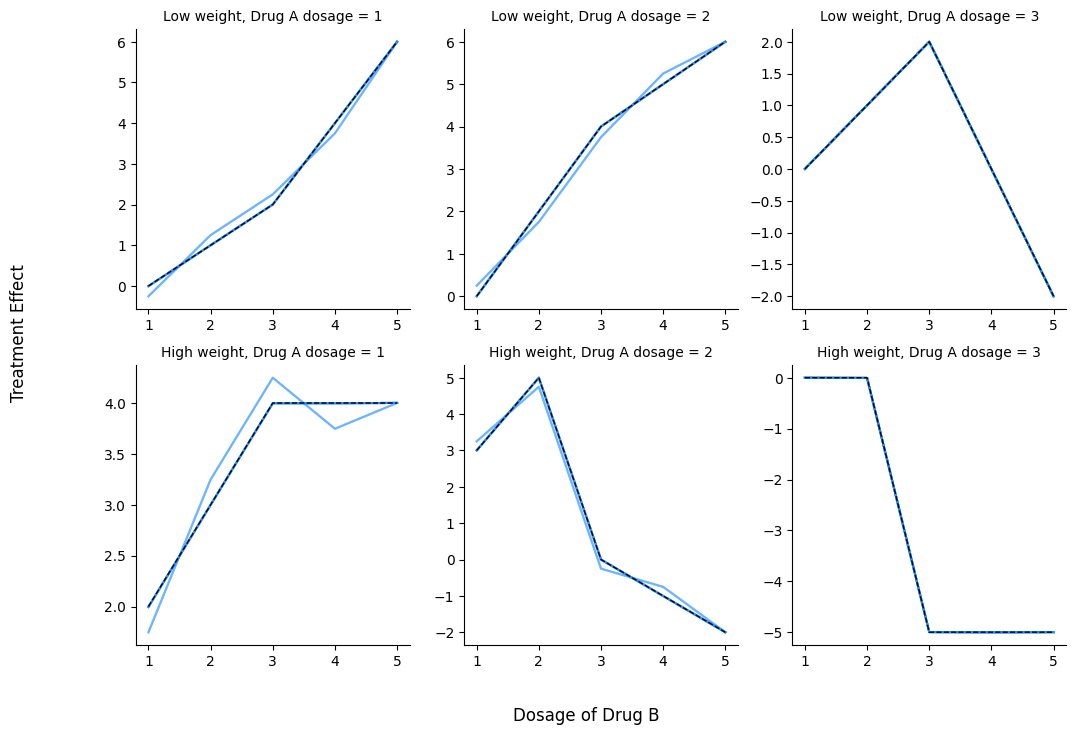

In [362]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

weights = ["Low", "High"]

for i in range(2):
    for j in range(3):
        ax[i, j].spines[['right', 'top']].set_visible(False)
        ax[i, j].set_xticks([1, 2, 3, 4, 5])
        title = f"{weights[i]} weight, Drug A dosage = {j+1}"
        ax[i, j].set_title(title, fontsize=10)

dosages = np.array([1, 2, 3, 4, 5])

for i in range(2):
    i1 = i + 1
    for j in range(3):
        j1 = j + 1
        
        
        for k in range(50):
            idx = losses_argsort[k]
            y_i = beta_est[idx][i][j]
            ax[i, j].plot(dosages, y_i, color="dodgerblue", linewidth=1.5, alpha=0.07)
            
        ax[i, j].plot(dosages, y_true[i][j], color="black", linewidth=1, linestyle="--",
               alpha=1)


fig.supxlabel("Dosage of Drug B")
fig.supylabel("Treatment Effect")

# plt.savefig("../Figures/slopes_sims/estimated_effect_panels.png", dpi=300, bbox_inches="tight")

plt.show()